## 3251-014 Statistics for Data Science
### Final Project : Frederick Ferguson : August 7, 2018

# Predicting Hair Salon Appointment No-shows.


<img src="stop-hair-salon-no-show.png">

### Table of Contents
<p></p>
<li>[Introduction](#introduction)</li>
<li>[The Dataset](#data-set)</li>
<li>[Acknowledgements](#acknowledgements)</li>
<li>[The Project](#project)</li>
<li>[Ingesting and Preprocessing the Data](#ingestion)</li>
<li>[Building the Model](#modeling)</li>
<li>[The Conclusion](#conclusion)</li>

<a id='introduction'></a>
### Introduction

No-shows are a big problem for hair salons the same as airlines and medical facilities. Excessive no-shows increase costs and wait times for businesses and all other customers alike. A No-show prediction service would allow hair salons to select from a variety of treatment options at the time of the booking such as requiring a non-refundable deposit or scheduling the appointment at a different time, location or with a different service provider such that the potential no-show would have less business and customer experience impact.

In this project we investigate a data set of appointment records in an actual hair salon in Toronto, Canada. The data includes whether the client showed up for the appointment or whether the appointment resulted in a "no show" wherein the client either didn't show up at all or canceled the appointment within 48 hours of the planned booking (i.e., an out-of-policy cancellation).  

My goal is to answer the question: <i>"Which client bookings are most likely to either 1) no-show or 2) cancel within 48 hours of the scheduled appointment time. False positives are okay as long as we can maximize the number of actual no shows predicted in test.</i>
<p></p>


<a id='data-set'></a>
<p></p>

### The Data Set
The data set is provided by <a href="https://www.salonlyol.ca/">Salon Lyol</a> a hair salon I opened on March 14th.  I have appointment data from March 14th to July 29th.

The dataset consists of: 
<li>813 clients</li>
<li>1952 total bookings</li>
<li>1728 revenue bookings</li>
<li>224 no-shows and out-of-policy cancellations (11.5%)</li>

<a href="https://www.kaggle.com/"><img src="kaggle.png" alt="Kaggle.com" style="width:72px;height:27px;border:0;"></a>

<p style="text-align:center;"><a href="https://www.kaggle.com/frederickferguson/hair-salon-no-show-data-set">     hair-salon-no-show-data-set</a></p>
<p></p>
<p>Datasets and models are available for predicting no-shows in healthcare but this is the first hair salon appointment dataset on Kaggle. The data consists primarily of attributes of the appointment booking itself and excludes client details or details on the staff member providing the service.</p>

<img src="Milano_software.png" width="800" height="534">


I engineered 21 features related to the current booking, the client’s last booking and the client’s cumulative totals.  no-show is the response variable.

#### BOOKING FEATURES

<li>time-of-day</li>
<li>day-of-week</li>
<li>service category (color or style)</li>
<li>staff code</li>
<li>no-show (true or false)</li>

#### LAST BOOKING FEATURES

<li>time-of-day</li>
<li>day-of-week</li>
<li>service category (color or style)</li>
<li>staff code</li>
<li>number of services</li>
<li>service revenue</li>
<li>receipt total</li>
<li>no-show (true or false)</li>
<li>product purchased (true or false)</li>

#### CUMULATIVE CLIENT FEATURES

<li>cumulative revenue</li>
<li>cumulative bookings</li>
<li>cumulative style services</li>
<li>cumulative color services</li>
<li>cumulative style vs. color ratio</li>
<li>cumulative product purchases</li>
<li>cumulative cancellations</li>
<li>cumulative no-shows</li>
<li>recency (days since last booking)</li>

<a id='acknowledgements'></a>
### Acknowledgements
The data was used with the permission of my hair salon, Salon Lyol in Toronto, Canada. 

<a href="https://www.salonlyol.ca/"><img src="Logo-1.png" alt="Salon Lyol"></a>

It covers a time series from March to July of 2018. The name of the salon is omitted for privacy reasons.

I was inspired by the extensive no-show analytics that has been done on Kaggle with appointment records from public hospitals in Vitoria, Espirito Santo, Brazil. The data set is provided by JoniHoppen on Kaggle: https://www.kaggle.com/joniarroba/noshowappointments . 


<a id='project'></a>
### The Project
Our aim is to help to answer a simple question:

"For a given booking with certain attributes, will the client showup at the scheduled date and time?" 

The project will focus primarily on:

<ol type="1">
  <li>attributes of the booking (e.g., time-of-day, day-of-week, service category, etc.)</li>
  <li>attributes of the client's previous booking (if any) before today</li> (e..g., last time-of-day, last day-of-week, last service category.)
  <li>historical, cumulative behavior attributes of the client (e.g., cumulative revenue, cumulative bookings to-date, cumulative no-shows to-date, etc.)</li>
</ol>

We will use the SKLearn LogisticRegression estimator with backward elimination.

In [1]:
import numpy as np
import math
import calendar
import pandas as pd
from pandas import DataFrame, Series
import scipy, scipy.stats
from scipy.stats import spearmanr
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from matplotlib.pyplot import figure
%matplotlib inline
rcParams['figure.figsize'] = 5,4

import sklearn
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
#from sklearn.pipeline import Pipeline

#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

S3_Path="https://s3.amazonaws.com/raichle-jupyter-notebook-server-bucket/3251SDS-Project/"

<a id='ingestion'></a>
### Ingesting and Preprocessing the Data

I will start by ingesting the service list, product list, bookings, cancellations and receipts.  Note that we have to merge the bookings and cancellations since bookings are removed once they are canceled.

In [2]:
# Read and parse service data
services = pd.read_csv(S3_Path+"Service+Listing.csv")
services=services.rename(columns={'Desc':'service_name','Code': 'service_code','Cate':'category'})
services.drop(['IsActive','Price','Cost'], axis=1, inplace=True) #Drop unused columns
print("Number of services is: ",len(services.index))
services[:5]

Number of services is:  33


,service_code,service_name,category
0,CAL,accent lights,COLOR
1,CALC,Accent lights and color,COLOR
2,CAS,Color additional service,COLOR
3,CBAL,Balayage,COLOR
4,CCAMO,Men's camo color,COLOR


In [3]:
# Read and parse product data
products = pd.read_csv(S3_Path+"Product+Listing.csv")
products.drop(['Supplier','Brand','Category','Price'], axis=1, inplace=True) #Drop unused columns
products=products.rename(columns={'Code':'product_code','Description': 'product_name'})
products.drop(['IsActive','On Hand','Minimum','Maximum','Cost','COG','YTD','Package'], axis=1, inplace=True) #Drop unused columns
print("Number of products is: ",len(products.index))
products[:5]

Number of products is:  101


,product_code,product_name
0,AGBALANCE335M,AG balance 355ml
1,AGBOOST355ML,AG Boost 355ml
2,AGCLOUD107ML,AG Cloud 107ml
3,AGDRYLIFT44ML,AG Dry Lift 44ml
4,AGREMEDY148ML,AG Remedy 148ml


In [4]:
# Read and parse bookings data
bookings = pd.read_csv(S3_Path+"Future+Bookings.csv")
print("Number of bookings (preprocessing) is: ",len(bookings.index))
bookings[:5]

Number of bookings (preprocessing) is:  1906


,Code,Staff,Service,Date,Time,TimeInt
0,JUNJ01,JJ,CON,03/14/2018,3:50:00 PM,950
1,NORJ01,JJ,SHCM,03/14/2018,4:00:00 PM,960
2,CORS01,JJ,SHCW,03/15/2018,2:10:00 PM,850
3,KERT01,JJ,SHCW,03/15/2018,10:00:00 AM,600
4,LEHJ01,JJ,SHCM,03/15/2018,6:00:00 PM,1080


In [5]:
# Preprocess bookings data
bookings.drop(['TimeInt'], axis=1, inplace=True) #Drop unused columns
bookings=bookings.rename(columns={'Code': 'client_code','Staff' : 'staff', 'Service' : 'book_scode', 'Date' : 'booking_date', 'Time' : 'booking_time'})
bookings['booking_dt'] = pd.to_datetime((bookings['booking_date'] + ' ' + bookings['booking_time']), format='%m/%d/%Y %I:%M:%S %p')
bookings['booking_date'] = pd.to_datetime(bookings['booking_date'], format='%m/%d/%Y')
bookings.drop(bookings[bookings.booking_date > '2018-07-29'].index, inplace=True) #Drop future bookings
bookings=bookings.dropna(subset=['client_code']) #Drop NaN client codes
bookings = pd.merge(bookings, services,  how='inner', left_on=['book_scode'], right_on = ['service_code'])
bookings.drop(['service_code','service_name'], axis=1, inplace=True) #Drop unused columns
bookings=bookings.rename(columns={'category': 'book_category'})
bookings['book_flag']=1
bookings['cancel_flag']=0
print("Number of bookings (post-processing) is: ",len(bookings.index))
bookings[:5]

Number of bookings (post-processing) is:  1716


,client_code,staff,book_scode,booking_date,booking_time,booking_dt,book_category,book_flag,cancel_flag
0,JUNJ01,JJ,CON,2018-03-14,3:50:00 PM,2018-03-14 15:50:00,MISC,1,0
1,DUFD01,JJ,CON,2018-03-23,10:40:00 AM,2018-03-23 10:40:00,MISC,1,0
2,HIMJ01,JJ,CON,2018-03-24,12:00:00 PM,2018-03-24 12:00:00,MISC,1,0
3,SLEA01,HOUSE,CON,2018-04-01,11:10:00 AM,2018-04-01 11:10:00,MISC,1,0
4,CULT01,SINEAD,CON,2018-04-10,6:30:00 PM,2018-04-10 18:30:00,MISC,1,0


In [6]:
# Read and parse cancellation data
cancellations = pd.read_csv(S3_Path+"Client+Cancellations.csv", parse_dates=[0,4])
print("Number of cancellations (pre-processing) is: ",len(cancellations.index))
cancellations[:5]

Number of cancellations (pre-processing) is:  243


,Cancel Date,Code,Service,Staff,Booking Date,Canceled By,Days
0,2018-05-22,MASA01,CFC,JOANNE,2018-05-24,ADMIN,2.0
1,2018-06-27,MASA01,CBAL,KELLY,2018-06-27,ADMIN,0.0
2,2018-07-03,MASA01,SHCM,BECKY,2018-07-10,BECKY,7.0
3,2018-07-10,MASA01,SHCC,JJ,2018-07-11,KELLY,1.0
4,2018-07-24,TRUA01,SHCM,KELLY,2018-07-24,TANYA,0.0


In [7]:
# Preprocess cancellation data
cancellations = pd.merge(cancellations, services,  how='inner', left_on=['Service'], right_on = ['service_code'])
cancellations[:5]

,Cancel Date,Code,Service,Staff,Booking Date,Canceled By,Days,service_code,service_name,category
0,2018-05-22,MASA01,CFC,JOANNE,2018-05-24,ADMIN,2.0,CFC,Color full color,COLOR
1,2018-07-10,JACA01,CFC,JOANNE,2018-07-11,BECKY,1.0,CFC,Color full color,COLOR
2,2018-07-10,JACA01,CFC,JOANNE,2018-07-11,JJ,1.0,CFC,Color full color,COLOR
3,2018-06-29,GAD*01,CFC,JOANNE,2018-06-29,BECKY,0.0,CFC,Color full color,COLOR
4,2018-05-25,MAEJ01,CFC,BECKY,2018-06-02,JJ,8.0,CFC,Color full color,COLOR


In [8]:
cancellations.drop(['service_code', 'service_name','Canceled By'], axis=1, inplace=True) #Drop unused columns
cancellations=cancellations.rename(columns={'category':'book_category','Cancel Date': 'cancel_date','Code':'client_code','Service' : 'book_scode', 'Staff' : 'staff', 'Booking Date' : 'booking_date', 'Days' : 'cancel_days'})
cancellations.drop(cancellations[cancellations.booking_date > '2018-07-29'].index, inplace=True) #Drop future booking cancellations
cancellations['book_flag']=0
cancellations['cancel_flag']=1
print("Number of cancellations (post-processing) is: ",len(cancellations.index))
cancellations[:5]

Number of cancellations (post-processing) is:  235


,cancel_date,client_code,book_scode,staff,booking_date,cancel_days,book_category,book_flag,cancel_flag
0,2018-05-22,MASA01,CFC,JOANNE,2018-05-24,2.0,COLOR,0,1
1,2018-07-10,JACA01,CFC,JOANNE,2018-07-11,1.0,COLOR,0,1
2,2018-07-10,JACA01,CFC,JOANNE,2018-07-11,1.0,COLOR,0,1
3,2018-06-29,GAD*01,CFC,JOANNE,2018-06-29,0.0,COLOR,0,1
4,2018-05-25,MAEJ01,CFC,BECKY,2018-06-02,8.0,COLOR,0,1


In [9]:
# Read and parse receipt data
receipts = pd.read_csv(S3_Path+"Receipt+Transactions.csv", parse_dates=[1])
print("Number of receipts is: ",len(receipts.index))
receipts[:5]

Number of receipts is:  1934


,Receipt,Date,Description,Client,Staff,Quantity,Amount,GST,PST
0,10,2018-03-15,Women's hair cut,KERT01,JJ,1,82.0,4.10,6.56
1,100,2018-04-05,Women's hair cut,COOM01,SINEAD,1,70.0,3.50,5.60
2,1000,2018-06-09,Consultation,PEDM01,JJ,1,0.0,0.00,0.00
3,1001,2018-06-09,Women's hair cut,BAIS01,KELLY,1,55.0,2.75,4.40
4,1003,2018-06-09,Women's hair cut,FRAL01,KELLY,1,65.0,3.25,5.20


In [10]:
# Preprocess receipt data
receipts.drop(['Quantity','GST','PST','Staff'], axis=1, inplace=True) #Drop unused columns
receipts=receipts.rename(columns={'Receipt':'receipt_no','Date' : 'receipt_date','Description':'service_name','Client': 'client_code','Amount':'amount'})
receipts[:5]

,receipt_no,receipt_date,service_name,client_code,amount
0,10,2018-03-15,Women's hair cut,KERT01,82.0
1,100,2018-04-05,Women's hair cut,COOM01,70.0
2,1000,2018-06-09,Consultation,PEDM01,0.0
3,1001,2018-06-09,Women's hair cut,BAIS01,55.0
4,1003,2018-06-09,Women's hair cut,FRAL01,65.0


In [11]:
# Select and process service receipts
receipts['receipt_tot'] = receipts.groupby(['receipt_no'])['amount'].transform('sum')
service_receipts = pd.merge(receipts, services,  how='inner', left_on=['service_name'], right_on = ['service_name'])
service_receipts=service_receipts.rename(columns={'service_code':'receipt_scode','category':'receipt_category','client_code':'receipt_client'})
service_receipts=service_receipts.rename(columns={})
service_receipts=service_receipts.drop_duplicates()
service_receipts=service_receipts.sort_values(['receipt_date','receipt_client'], ascending=[True, True])
print("Number of service receipts is: ",len(service_receipts.index))
service_receipts[:5]

Number of service receipts is:  1759


,receipt_no,receipt_date,service_name,receipt_client,amount,receipt_tot,receipt_scode,receipt_category
562,8,2018-03-15,Women's hair cut,CORS01,82.0,82.0,SHCW,STYLE
0,10,2018-03-15,Women's hair cut,KERT01,82.0,82.0,SHCW,STYLE
1194,13,2018-03-15,Men's hair cut,LEHJ01,40.0,40.0,SHCM,STYLE
652,11,2018-03-15,Consultation,SCHJ01,0.0,0.0,CON,MISC
1137,11,2018-03-15,Men's hair cut,SCHJ01,0.0,0.0,SHCM,STYLE


In [12]:
# Select and process product receipts
product_receipts = pd.merge(receipts, products,  how='inner', left_on=['service_name'], right_on = ['product_name'])
product_receipts=product_receipts.sort_values(['receipt_date','client_code'], ascending=[True, True])
product_receipts=product_receipts.drop_duplicates()
print("Number of product receipts is: ",len(product_receipts.index))
product_receipts[:5]

Number of product receipts is:  176


,receipt_no,receipt_date,service_name,client_code,amount,receipt_tot,product_code,product_name
16,69,2018-04-03,PO hydrate sh 250ml,LINJ01,32.44,114.44,POHSH250ML,PO hydrate sh 250ml
161,75,2018-04-03,Shu color lustre sh 300ml,WALK_IN,43.70,96.90,SHU CL SH300M,Shu color lustre sh 300ml
163,75,2018-04-03,Shu color lustre con 250ml,WALK_IN,53.20,96.90,SHU CL CON250M,Shu color lustre con 250ml
171,89,2018-04-04,PO SC superfood masque 150ml,KEN*01,38.31,108.31,POSCSM150ML,PO SC superfood masque 150ml
48,115,2018-04-06,elchim dryer,SINM01,199.20,281.20,ELCHIM DRYER,elchim dryer


In [13]:
# We have to merge the bookings and cancellations since bookings are removed once they are canceled.
print("Number of bookings is: ",len(bookings.index))
print("Number of cancellations is: ",len(cancellations.index))
data1 = pd.concat([bookings, cancellations], ignore_index=True, sort=True)

print("Combined is: ",len(data1.index))
data1.head(5)

Number of bookings is:  1716
Number of cancellations is:  235
Combined is:  1951


,book_category,book_flag,book_scode,booking_date,booking_dt,booking_time,cancel_date,cancel_days,cancel_flag,client_code,staff
0,MISC,1,CON,2018-03-14,2018-03-14 15:50:00,3:50:00 PM,NaT,NaN,0,JUNJ01,JJ
1,MISC,1,CON,2018-03-23,2018-03-23 10:40:00,10:40:00 AM,NaT,NaN,0,DUFD01,JJ
2,MISC,1,CON,2018-03-24,2018-03-24 12:00:00,12:00:00 PM,NaT,NaN,0,HIMJ01,JJ
3,MISC,1,CON,2018-04-01,2018-04-01 11:10:00,11:10:00 AM,NaT,NaN,0,SLEA01,HOUSE
4,MISC,1,CON,2018-04-10,2018-04-10 18:30:00,6:30:00 PM,NaT,NaN,0,CULT01,SINEAD


In [14]:
# Group bookings by booking_dt and client_code and count same-day services.  We will use this later.
data1['day_services'] = data1.groupby(['booking_date','client_code'])['book_flag'].transform('sum')
data1=data1.sort_values(['client_code','booking_date'], ascending=[True,True])
data1[:5]

,book_category,book_flag,book_scode,booking_date,booking_dt,booking_time,cancel_date,cancel_days,cancel_flag,client_code,staff,day_services
699,STYLE,1,SHCW,2018-05-23,2018-05-23 13:10:00,1:10:00 PM,NaT,NaN,0,.L01,JJ,2
1620,COLOR,1,CHLPHC,2018-05-23,2018-05-23 10:40:00,10:40:00 AM,NaT,NaN,0,.L01,JOANNE,2
1807,STYLE,0,SHCW,2018-06-27,NaT,NaN,2018-06-22,5.0,1,.L01,JJ,0
1263,STYLE,1,SBD,2018-06-14,2018-06-14 13:30:00,1:30:00 PM,NaT,NaN,0,?A01,KELLY,1
1287,STYLE,1,SBD,2018-06-23,2018-06-23 16:30:00,4:30:00 PM,NaT,NaN,0,?A01,KELLY,1


In [15]:
# Merge the receipts with the bookings and create a few features
def morning(h):
    if np.isnan(h):
        return h
    elif h < 12:
        return "morning"
    elif 12 <= h < 16:
        return "afternoon"
    elif h >= 16:
        return "evening"


data2 = pd.merge(data1, service_receipts,  how='left', left_on=['booking_date','client_code','book_scode'], right_on = ['receipt_date','receipt_client','receipt_scode'])
data2 = data2.reset_index(drop=True)

data2['receipt_tot'].fillna(0, inplace=True)
data2['amount'].fillna(0, inplace=True)
print("Number of bookings: ",len(data2.index))
data2['booking_date']= pd.to_datetime(data2['booking_date'])
data2['book_dow']= data2['booking_date'].dt.weekday_name
data2['book_hour'] = data2['booking_dt'].dt.hour
data2['book_tod'] = data2['book_hour'].apply(morning)
data2.drop(['booking_time','book_hour','booking_dt','receipt_client','receipt_no','service_name','receipt_date','receipt_scode'], axis=1, inplace=True) #Drop unused columns

Number of bookings:  1952


In [16]:
# Apply No Show Policy
# 1) One non-revenue consultation with no cancel date is NOT a no show.  They probably did show up.
# 2) Revenue generated and it is not the case that (the number of services equals 1 and service code is consultation) is NOT a no show.
# 3) Non-revenue booking but cancellation date is more than two days before the booking is NOT a no show.

bookings=len(data2.index)
data3 = data2[(data2['amount'] == 0) & (data2['day_services'] == 1) & (data2['book_scode'] == 'CON') & (data2['cancel_date'].isnull())]
consultations=len(data3.index)
data4 = data2[(data2['receipt_tot'] > 0) & ~((data2['day_services'] == 1) & (data2['book_scode'] == 'CON'))]
revenue=len(data4.index)
data5 = data2[(data2['receipt_tot'] == 0) & (data2['cancel_date'].notnull() & (data2['cancel_days'] >= 2) )]
ip_cancellations=len(data5.index)
data7 = pd.concat([data3,data4,data5])
data7.sort_index(inplace=True)

data8=data2.copy()
ip_rows=data7.index.tolist()
data8=data2.loc[~data2.index.isin(ip_rows)]
print("Total bookings is: ",bookings)
print("Non-revenue consultations is: ",consultations)
print("Revenue bookings is: ",revenue)
print("In policy cancellations is: ",ip_cancellations)
print("Out of policy cancels and no-shows is: ",bookings-consultations-revenue-ip_cancellations)

Total bookings is:  1952
Non-revenue consultations is:  47
Revenue bookings is:  1585
In policy cancellations is:  96
Out of policy cancels and no-shows is:  224


In [17]:
# Create response variable "noshow"

clients=data2['client_code'].unique()
print("Number of clients is: ",len(clients))
data7=data7.copy()
data7['noshow']=0
data8=data8.copy()
data8['noshow']=1
in_policy=len(data7.index)
out_of_policy=len(data8.index)

data9 = pd.concat([data7, data8], ignore_index=True)
data9.drop(['receipt_category','cancel_date','cancel_days','book_scode'], axis=1, inplace=True) #Drop unused columns
total=len(data9.index)
print("Total in policy is: ",in_policy)
print("Total out of policy is: ",out_of_policy)
print("Total is: ",total)
data10 = data9.sort_values(['booking_date','client_code'], ascending=[True, True])
data10.head(5)

Number of clients is:  813
Total in policy is:  1728
Total out of policy is:  224
Total is:  1952


,book_category,book_flag,booking_date,cancel_flag,client_code,staff,day_services,amount,receipt_tot,book_dow,book_tod,noshow
718,MISC,1,2018-03-14,0,JUNJ01,JJ,1,0.0,0.0,Wednesday,afternoon,0
1871,STYLE,1,2018-03-14,0,NORJ01,JJ,1,0.0,0.0,Wednesday,evening,1
324,STYLE,1,2018-03-15,0,CORS01,JJ,1,82.0,82.0,Thursday,afternoon,0
742,STYLE,1,2018-03-15,0,KERT01,JJ,1,82.0,82.0,Thursday,morning,0
853,STYLE,1,2018-03-15,0,LEHJ01,JJ,1,40.0,40.0,Thursday,evening,0


In [18]:
# Create client cumulative total features against prior bookings

def is_prod(row):
    if row['receipt_tot'] > row['amount']:
        val = 1
    else:
        val = 0
    return val

def is_style(row):
    if row['book_category'] == 'STYLE':
        val = 1
    else:
        val = 0
    return val

def is_color(row):
    if row['book_category'] == 'COLOR':
        val = 1
    else:
        val = 0
    return val

def f_cumcatratio(row):
    if row['cumcolor']>0:
        val = row['cumstyle']/row['cumcolor']
    else:
        val = 0
    return val

data10 = data10.reset_index(drop=True)
data10['index'] = data10.index
data10['counter'] = 1
data10['prod_flag'] = data10.apply(is_prod, axis=1)
data10['cumrev'] = (data10['amount']).groupby(data10['client_code']).cumsum()
data10['cumbook'] = (data10['counter']).groupby(data10['client_code']).cumsum()
data10['cumstyle'] = data10.apply(is_style, axis=1).groupby(data10['client_code']).cumsum()
data10['cumcolor'] = data10.apply(is_color, axis=1).groupby(data10['client_code']).cumsum()
data10['cumcatratio'] = data10.apply(f_cumcatratio, axis=1)
data10['cumprod'] = (data10['prod_flag']).groupby(data10['client_code']).cumsum()
data10['cumcancel'] = (data10['cancel_flag']).groupby(data10['client_code']).cumsum()
data10['cumnoshow'] = (data10['noshow']).groupby(data10['client_code']).cumsum()
data10.sort_values('book_category')
data10.head(10)

,book_category,book_flag,booking_date,cancel_flag,client_code,staff,day_services,amount,receipt_tot,book_dow,book_tod,noshow,index,counter,prod_flag,cumrev,cumbook,cumstyle,cumcolor,cumcatratio,cumprod,cumcancel,cumnoshow
0,MISC,1,2018-03-14,0,JUNJ01,JJ,1,0.0,0.0,Wednesday,afternoon,0,0,1,0,0.0,1,0,0,0.0,0,0,0
1,STYLE,1,2018-03-14,0,NORJ01,JJ,1,0.0,0.0,Wednesday,evening,1,1,1,0,0.0,1,1,0,0.0,0,0,1
2,STYLE,1,2018-03-15,0,CORS01,JJ,1,82.0,82.0,Thursday,afternoon,0,2,1,0,82.0,1,1,0,0.0,0,0,0
3,STYLE,1,2018-03-15,0,KERT01,JJ,1,82.0,82.0,Thursday,morning,0,3,1,0,82.0,1,1,0,0.0,0,0,0
4,STYLE,1,2018-03-15,0,LEHJ01,JJ,1,40.0,40.0,Thursday,evening,0,4,1,0,40.0,1,1,0,0.0,0,0,0
5,STYLE,1,2018-03-15,0,SCHJ01,JJ,2,0.0,0.0,Thursday,afternoon,1,5,1,0,0.0,1,1,0,0.0,0,0,1
6,COLOR,1,2018-03-15,0,SCHJ01,JJ,2,0.0,0.0,Thursday,afternoon,1,6,1,0,0.0,2,1,1,1.0,0,0,2
7,STYLE,1,2018-03-15,0,SCHJ02,JJ,1,40.0,40.0,Thursday,afternoon,0,7,1,0,40.0,1,1,0,0.0,0,0,0
8,STYLE,1,2018-03-15,0,THOD01,JJ,1,40.0,40.0,Thursday,afternoon,0,8,1,0,40.0,1,1,0,0.0,0,0,0
9,STYLE,1,2018-03-16,0,CHEW01,JJ,1,82.0,82.0,Friday,morning,0,9,1,0,82.0,1,1,0,0.0,0,0,0


In [19]:
data11=data10.copy()
data11.drop(['book_flag','cancel_flag','index','counter'], axis=1, inplace=True) #Drop unused columns

# Rename columns for the conditional complex shift
data11.columns=['last_category','last_book_date','client_code','last_staff','last_day_services','last_amount','last_receipt_tot','last_dow','last_tod','last_noshow','last_prod_flag','last_cumrev','last_cumbook','last_cumstyle','last_cumcolor','last_cumcatratio','last_cumprod','last_cumcancel','last_cumnoshow']
data11.head(10)

,last_category,last_book_date,client_code,last_staff,last_day_services,last_amount,last_receipt_tot,last_dow,last_tod,last_noshow,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumcatratio,last_cumprod,last_cumcancel,last_cumnoshow
0,MISC,2018-03-14,JUNJ01,JJ,1,0.0,0.0,Wednesday,afternoon,0,0,0.0,1,0,0,0.0,0,0,0
1,STYLE,2018-03-14,NORJ01,JJ,1,0.0,0.0,Wednesday,evening,1,0,0.0,1,1,0,0.0,0,0,1
2,STYLE,2018-03-15,CORS01,JJ,1,82.0,82.0,Thursday,afternoon,0,0,82.0,1,1,0,0.0,0,0,0
3,STYLE,2018-03-15,KERT01,JJ,1,82.0,82.0,Thursday,morning,0,0,82.0,1,1,0,0.0,0,0,0
4,STYLE,2018-03-15,LEHJ01,JJ,1,40.0,40.0,Thursday,evening,0,0,40.0,1,1,0,0.0,0,0,0
5,STYLE,2018-03-15,SCHJ01,JJ,2,0.0,0.0,Thursday,afternoon,1,0,0.0,1,1,0,0.0,0,0,1
6,COLOR,2018-03-15,SCHJ01,JJ,2,0.0,0.0,Thursday,afternoon,1,0,0.0,2,1,1,1.0,0,0,2
7,STYLE,2018-03-15,SCHJ02,JJ,1,40.0,40.0,Thursday,afternoon,0,0,40.0,1,1,0,0.0,0,0,0
8,STYLE,2018-03-15,THOD01,JJ,1,40.0,40.0,Thursday,afternoon,0,0,40.0,1,1,0,0.0,0,0,0
9,STYLE,2018-03-16,CHEW01,JJ,1,82.0,82.0,Friday,morning,0,0,82.0,1,1,0,0.0,0,0,0


In [20]:
# Create current booking columns
data11['book_date']=data11['last_book_date']
data11['book_dow']=data11['last_dow']
data11['book_tod']=data11['last_tod']
data11['book_category']=data11['last_category']
data11['book_staff']=data11['last_staff']
#data11['book_prod_flag']=data11['last_prod_flag']
data11['noshow']=data11['last_noshow']

# Rearrange columns
cols = data11.columns.tolist()
cols.insert(0, cols.pop(cols.index('book_staff')))
#cols.insert(0, cols.pop(cols.index('book_prod_flag')))
cols.insert(0, cols.pop(cols.index('book_category')))
cols.insert(0, cols.pop(cols.index('book_dow')))
cols.insert(0, cols.pop(cols.index('book_tod')))
cols.insert(0, cols.pop(cols.index('book_date')))
#cols.insert(0, cols.pop(cols.index('client_code')))
data11 = data11.reindex(columns= cols)
data11.head(10)

,book_date,book_tod,book_dow,book_category,book_staff,last_category,last_book_date,client_code,last_staff,last_day_services,last_amount,last_receipt_tot,last_dow,last_tod,last_noshow,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumcatratio,last_cumprod,last_cumcancel,last_cumnoshow,noshow
0,2018-03-14,afternoon,Wednesday,MISC,JJ,MISC,2018-03-14,JUNJ01,JJ,1,0.0,0.0,Wednesday,afternoon,0,0,0.0,1,0,0,0.0,0,0,0,0
1,2018-03-14,evening,Wednesday,STYLE,JJ,STYLE,2018-03-14,NORJ01,JJ,1,0.0,0.0,Wednesday,evening,1,0,0.0,1,1,0,0.0,0,0,1,1
2,2018-03-15,afternoon,Thursday,STYLE,JJ,STYLE,2018-03-15,CORS01,JJ,1,82.0,82.0,Thursday,afternoon,0,0,82.0,1,1,0,0.0,0,0,0,0
3,2018-03-15,morning,Thursday,STYLE,JJ,STYLE,2018-03-15,KERT01,JJ,1,82.0,82.0,Thursday,morning,0,0,82.0,1,1,0,0.0,0,0,0,0
4,2018-03-15,evening,Thursday,STYLE,JJ,STYLE,2018-03-15,LEHJ01,JJ,1,40.0,40.0,Thursday,evening,0,0,40.0,1,1,0,0.0,0,0,0,0
5,2018-03-15,afternoon,Thursday,STYLE,JJ,STYLE,2018-03-15,SCHJ01,JJ,2,0.0,0.0,Thursday,afternoon,1,0,0.0,1,1,0,0.0,0,0,1,1
6,2018-03-15,afternoon,Thursday,COLOR,JJ,COLOR,2018-03-15,SCHJ01,JJ,2,0.0,0.0,Thursday,afternoon,1,0,0.0,2,1,1,1.0,0,0,2,1
7,2018-03-15,afternoon,Thursday,STYLE,JJ,STYLE,2018-03-15,SCHJ02,JJ,1,40.0,40.0,Thursday,afternoon,0,0,40.0,1,1,0,0.0,0,0,0,0
8,2018-03-15,afternoon,Thursday,STYLE,JJ,STYLE,2018-03-15,THOD01,JJ,1,40.0,40.0,Thursday,afternoon,0,0,40.0,1,1,0,0.0,0,0,0,0
9,2018-03-16,morning,Friday,STYLE,JJ,STYLE,2018-03-16,CHEW01,JJ,1,82.0,82.0,Friday,morning,0,0,82.0,1,1,0,0.0,0,0,0,0


In [21]:
# Conditioanl Complex Shift attributes from the last booking before today.

data12=data11.sort_values(['client_code','book_date'])

# NaN the "last values" for a given booking
def nanrow(booking):
    booking.last_book_date=np.nan
    booking.last_category=np.nan
    booking.last_staff=np.nan
    booking.last_prod_flag=np.nan
    booking.last_category=np.nan
    booking.last_prod_flag=np.nan
    booking.last_dow=np.nan 
    booking.last_tod=np.nan
    booking.last_day_services=np.nan
    booking.last_amount=np.nan
    booking.last_receipt_tot=np.nan
    booking.last_noshow=np.nan
    booking.last_cumrev=np.nan
    booking.last_cumbook=np.nan
    booking.last_cumstyle=np.nan
    booking.last_cumcolor=np.nan
    booking.last_cumcatratio=np.nan
    booking.last_cumprod=np.nan
    booking.last_cumcancel=np.nan
    booking.last_cumnoshow=np.nan
    return(booking)

# Set the "last values" of each of a given client's booking to the values from the most recent booking BEFORE today.
def smart_shift(client,bookings):
    count=len(bookings)
    
    # Only one booking
    if count == 1:
        bookings.loc[[0]]=nanrow(bookings.loc[[0]])
        
    # More than one booking
    else:
        # Get first booking of client
        first_date=bookings.loc[0,'book_date']
        match_count=len(bookings[bookings['book_date']==first_date])
        
        # Iterate backward through all of the given client's bookings from current to first
        for i in range(len(bookings)-1,0,-1):
            todays_date=bookings.loc[i,'book_date']

            # This is not the first booking of the client so get the most recent 'previous_date' before today
            if todays_date > first_date:
                previous1=bookings[bookings['book_date']<todays_date]
                previous2=previous1['book_date'].max()
                previous3=bookings[bookings['book_date']==previous2]
                previous4=previous3.reset_index()
                previous_date=previous4['index'].max()

                # Assign "last values" from previous booking
                bookings.loc[i, 'last_prod_flag'] = bookings.loc[previous_date, 'last_prod_flag']
                bookings.loc[i, 'last_book_date'] = bookings.loc[previous_date, 'last_book_date'].date()
                bookings.loc[i, 'last_dow'] = bookings.loc[previous_date, 'last_dow']         
                bookings.loc[i, 'last_tod'] = bookings.loc[previous_date, 'last_tod']          
                bookings.loc[i, 'last_category'] = bookings.loc[previous_date, 'last_category']
                bookings.loc[i, 'last_staff'] = bookings.loc[previous_date, 'last_staff']
                bookings.loc[i, 'last_prod_flag'] = bookings.loc[previous_date, 'last_prod_flag']
                bookings.loc[i, 'last_day_services'] = bookings.loc[previous_date, 'last_day_services']
                bookings.loc[i, 'last_amount'] = bookings.loc[previous_date, 'last_amount']
                bookings.loc[i, 'last_receipt_tot'] = bookings.loc[previous_date, 'last_receipt_tot']
                bookings.loc[i, 'last_noshow'] = bookings.loc[previous_date, 'last_noshow']
                bookings.loc[i, 'last_cumrev'] = bookings.loc[previous_date, 'last_cumrev']
                bookings.loc[i, 'last_cumbook'] = bookings.loc[previous_date, 'last_cumbook']
                bookings.loc[i, 'last_cumstyle'] = bookings.loc[previous_date, 'last_cumstyle']
                bookings.loc[i, 'last_cumcolor'] = bookings.loc[previous_date, 'last_cumcolor']
                bookings.loc[i, 'last_cumcatratio'] = bookings.loc[previous_date, 'last_cumcatratio']
                bookings.loc[i, 'last_cumprod'] = bookings.loc[previous_date, 'last_cumprod']
                bookings.loc[i, 'last_cumcancel'] = bookings.loc[previous_date, 'last_cumcancel']
                bookings.loc[i, 'last_cumnoshow'] = bookings.loc[previous_date, 'last_cumnoshow']

        # Finally NaN the "last values" on the first booking        
        for i in range(0, match_count):
            bookings.loc[[i]]=nanrow(bookings.loc[[i]])

    return bookings

data14 = pd.DataFrame()

# Get the set of unique clients
data13=data12['client_code'].unique()
print("Number of unique clients is: ",len(clients))

# Iterate through all clients
for client in clients:
    # Select each client's bookings
    client_bookings=data12.loc[data12.client_code == client]
    client_bookings=client_bookings.reset_index(drop=True)
    
    # "Smart Shift" the client's "last values"
    data13=smart_shift(client,client_bookings)

    # Collect the results
    data14=data14.append(data13)

data14 = data14.reset_index(drop=True)


Number of unique clients is:  813


In [22]:
# Calculate recency
data15=data14.copy()
data15['last_book_date'] = pd.to_datetime(data15['last_book_date'])
data15['recency'] = (data15['book_date']-data15['last_book_date']).dt.days

In [23]:
# Fill numeric NaNs
cols=['last_day_services','last_amount','last_prod_flag','last_receipt_tot','last_noshow','last_cumrev','last_cumbook','last_cumstyle','last_cumcolor','last_cumcatratio','last_cumprod','last_cumcancel','last_cumnoshow','recency']
data15[cols]=data15[cols].fillna(0)

# Fill categorical NaNs
cols=['book_tod','book_dow','last_tod','last_dow','book_category','last_category','book_staff','last_staff']
data15[cols]=data15[cols].fillna('')

data15.tail(10)

,book_date,book_tod,book_dow,book_category,book_staff,last_category,last_book_date,client_code,last_staff,last_day_services,last_amount,last_receipt_tot,last_dow,last_tod,last_noshow,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumcatratio,last_cumprod,last_cumcancel,last_cumnoshow,noshow,recency
1942,2018-05-04,afternoon,Friday,STYLE,BECKY,,NaT,ZIMJ01,,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1943,2018-06-08,afternoon,Friday,STYLE,JJ,STYLE,2018-05-04,ZIMJ01,BECKY,1.0,30.0,30.0,Friday,afternoon,0.0,0.0,30.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,35.0
1944,2018-07-12,afternoon,Thursday,STYLE,JJ,STYLE,2018-06-08,ZIMJ01,JJ,1.0,60.0,60.0,Friday,afternoon,0.0,0.0,90.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,34.0
1945,2018-07-27,morning,Friday,MISC,JJ,STYLE,2018-07-12,ZIMJ01,JJ,1.0,60.0,60.0,Thursday,afternoon,0.0,0.0,150.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0,15.0
1946,2018-04-25,evening,Wednesday,STYLE,SINEAD,,NaT,ZUGL01,,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1947,2018-04-19,afternoon,Thursday,STYLE,BECKY,,NaT,ZUKS01,,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1948,2018-05-29,afternoon,Tuesday,STYLE,BECKY,STYLE,2018-04-19,ZUKS01,BECKY,1.0,30.0,30.0,Thursday,afternoon,0.0,0.0,30.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,40.0
1949,2018-05-29,,Tuesday,STYLE,BECKY,STYLE,2018-04-19,ZUKS01,BECKY,1.0,30.0,30.0,Thursday,afternoon,0.0,0.0,30.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,40.0
1950,2018-06-26,afternoon,Tuesday,STYLE,BECKY,STYLE,2018-05-29,ZUKS01,BECKY,1.0,50.0,50.0,Tuesday,,0.0,0.0,130.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0,28.0
1951,2018-06-26,,Tuesday,STYLE,BECKY,STYLE,2018-05-29,ZUKS01,BECKY,1.0,50.0,50.0,Tuesday,,0.0,0.0,130.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0,28.0


In [24]:
data15.drop(['book_date','client_code','last_book_date','last_amount'], axis=1, inplace=True) #Drop unused columns
wrangled_df=data15
wrangled_df.to_csv('hair_salon_no_show_wrangled_df')
data15.head(10)

,book_tod,book_dow,book_category,book_staff,last_category,last_staff,last_day_services,last_receipt_tot,last_dow,last_tod,last_noshow,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumcatratio,last_cumprod,last_cumcancel,last_cumnoshow,noshow,recency
0,afternoon,Wednesday,STYLE,JJ,,,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,morning,Wednesday,COLOR,JOANNE,,,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,,Wednesday,STYLE,JJ,COLOR,JOANNE,2.0,262.0,Wednesday,morning,0.0,1.0,262.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0,35.0
3,afternoon,Thursday,STYLE,KELLY,,,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,evening,Saturday,STYLE,KELLY,STYLE,KELLY,1.0,35.0,Thursday,afternoon,0.0,0.0,35.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,9.0
5,afternoon,Saturday,STYLE,KELLY,STYLE,KELLY,1.0,55.0,Saturday,evening,0.0,0.0,90.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,14.0
6,afternoon,Saturday,STYLE,KELLY,STYLE,KELLY,1.0,35.0,Saturday,afternoon,0.0,0.0,145.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0,14.0
7,,Saturday,STYLE,KELLY,STYLE,KELLY,1.0,35.0,Saturday,afternoon,0.0,0.0,145.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0,14.0
8,evening,Thursday,STYLE,BECKY,,,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
9,afternoon,Friday,STYLE,BECKY,STYLE,BECKY,1.0,76.0,Thursday,evening,0.0,1.0,30.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,36.0


<a id='modeling'></a>
### Building the Model

I will build the model with SKLearn linear_model LogisticRegression applying backward elimination.  

I will use get_dummies to encode categoricals: 

<li>booking time-of-day (book_tod)</li>
<li>last booking time-of-day (last_tod)</li>
<li>last booking day-of-week (last_dow)</li>
<li>booking service category (book_category)</li>
<li>last booking service category (last_category)</li>

I will scale large numbericals: 
<li>client cumulative revenue (last_cumrev)</li>
<li>last receipt total (last_receipt_tot)</li>
<li>days since last booking (recency)</li>
<li>client cumulative number of bookings (last_cumbook)</li>
<li>client cumulative number of styling bookings (last_cumstyle)</li>
<li>client cumulative number of color bookings (last_cumcolor)</li>
<li>client cumulative number of product purchases (last_cumprod)</li>
<li>client last booking number of services (last_day_services)</li>


In [25]:
def run_regression(X,y,show,plot,title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7.0, random_state=0)

    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)

    predictions = logisticRegr.predict(X_test)
  #  f1 = f1_score(y_test, predictions)
 #   features=list(X)
 #   var_imp = logisticRegr.coef_[0]
    
    
    feature_importance = abs(logisticRegr.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    if show==1:

        featfig = plt.figure(figsize=(10, 8))
        featax = featfig.add_subplot(1, 1, 1)
        featax.barh(pos, feature_importance[sorted_idx], align='center')
        featax.set_yticks(pos)
        featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=12)
        featax.set_xlabel('Relative Feature Importance')
    
        plt.tight_layout()   
        plt.show()


    pred_df=pd.DataFrame({"preds":predictions})
    
    score = logisticRegr.score(X_test, y_test)
        
    probs = logisticRegr.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the Receiver Operating Characteristic
    if plot == 1:
        plt.title(title)
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    if show==2:
        print("y_test")
        print(y_test)
        print("predictions")
        print(pred_df)
        print('Score is %0.4f and ROC AUC is %0.4f' % (score, roc_auc))
        
    # Combine test and predictions dataframes
    X_test=X_test.reset_index()    
    y_test=y_test.reset_index()  
    pred_df=pred_df.reset_index()
    combined_df=pd.concat([X_test,y_test,pred_df], axis=1)
    combined_df.to_csv("combined_df.csv")

    return score, roc_auc

# Find candidates for Backward Elimination
def iterate_drop_cols(X1,y1,feature_cols1):
    for col in feature_cols1:
        X2 = X1.drop(col, 1)
        score1, roc_auc1 = run_regression(X2,y1,0,0,'Receiver Operating Characteristic')
        print('Dropping %s : Score is %0.4f and ROC AUC is %0.4f' % (col, score1, roc_auc1))
    return

In [26]:
#Define scaling function for 'last_cumrev','last_receipt_tot' and 'recency'
scaler = preprocessing.MinMaxScaler()

min_max_scaler = preprocessing.MinMaxScaler()

def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df


In [27]:
rawdata = data15
feature_cols=list(rawdata)
feature_cols.remove('book_staff') # eliminate staff codes to avoid overfitting 
feature_cols.remove('last_staff') # eliminate staff codes to avoid overfitting 

data=wrangled_df.dropna(subset = feature_cols)
data = data.reset_index(drop=True)
X=data.loc[:,feature_cols]

# Encode categoricals
X = pd.get_dummies(data=X, columns=['book_tod','last_tod','book_dow','last_dow','book_category','last_category'])

y=data.loc[:,'noshow']

# Drop NaN categoricals
X = X.drop('book_tod_', 1)
X = X.drop('last_dow_', 1)
X = X.drop('last_tod_', 1)
X = X.drop('last_category_', 1)

# Scale large numericals
X = scaleColumns(X,['last_cumrev','last_receipt_tot','recency','last_cumbook','last_cumstyle','last_cumcolor','last_cumprod','last_day_services'])

X.to_csv('hair_salon_no_show_wrangled_df.csv')

# Drop response variable from X
X = X.drop('noshow', 1)

X.head(10)

,last_day_services,last_receipt_tot,last_noshow,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumcatratio,last_cumprod,last_cumcancel,last_cumnoshow,recency,book_tod_afternoon,book_tod_evening,book_tod_morning,last_tod_afternoon,last_tod_evening,last_tod_morning,book_dow_Friday,book_dow_Monday,book_dow_Saturday,book_dow_Sunday,book_dow_Thursday,book_dow_Tuesday,book_dow_Wednesday,last_dow_Friday,last_dow_Monday,last_dow_Saturday,last_dow_Sunday,last_dow_Thursday,last_dow_Tuesday,last_dow_Wednesday,book_category_COLOR,book_category_MISC,book_category_STYLE,last_category_COLOR,last_category_MISC,last_category_STYLE
0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.666667,0.684431,0.0,1.0,0.205329,0.10,0.055556,0.142857,1.0,0.181818,0.0,0.0,0.263158,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0
3,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.333333,0.091432,0.0,0.0,0.027429,0.05,0.055556,0.000000,0.0,0.000000,0.0,0.0,0.067669,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
5,0.333333,0.143678,0.0,0.0,0.070533,0.10,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.105263,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
6,0.333333,0.091432,0.0,0.0,0.113636,0.15,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.105263,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
7,0.333333,0.091432,0.0,0.0,0.113636,0.15,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.105263,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
8,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0.333333,0.198537,0.0,1.0,0.023511,0.05,0.055556,0.000000,0.0,0.090909,0.0,0.0,0.270677,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


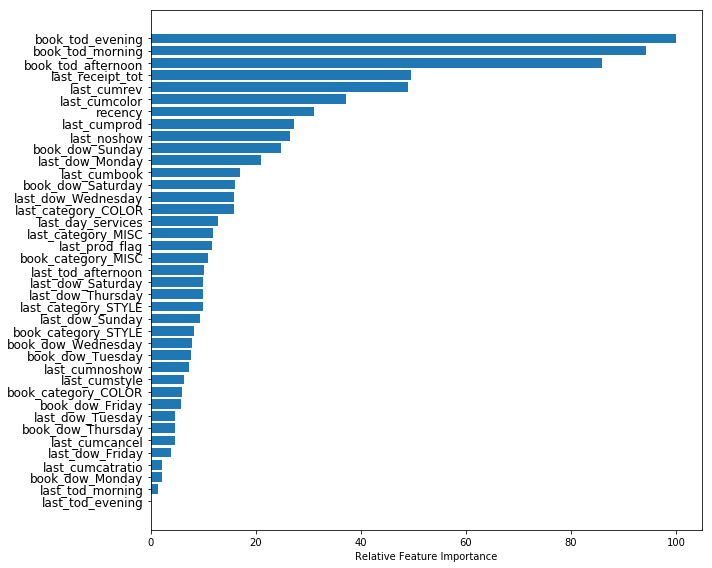

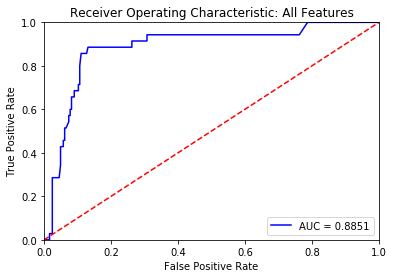

Score is 0.8602 and ROC AUC is 0.8851


In [28]:
score, roc_auc=run_regression(X,y,1,1,'Receiver Operating Characteristic: All Features')
print('Score is %0.4f and ROC AUC is %0.4f' % (score, roc_auc))

In [29]:
feature_cols=list(X)
feature_cols
iterate_drop_cols(X,y,feature_cols)

Dropping last_day_services : Score is 0.8602 and ROC AUC is 0.8861
Dropping last_receipt_tot : Score is 0.8638 and ROC AUC is 0.8791
Dropping last_noshow : Score is 0.8710 and ROC AUC is 0.8905
Dropping last_prod_flag : Score is 0.8602 and ROC AUC is 0.8787
Dropping last_cumrev : Score is 0.8674 and ROC AUC is 0.8806
Dropping last_cumbook : Score is 0.8602 and ROC AUC is 0.8824
Dropping last_cumstyle : Score is 0.8602 and ROC AUC is 0.8854
Dropping last_cumcolor : Score is 0.8602 and ROC AUC is 0.8844
Dropping last_cumcatratio : Score is 0.8674 and ROC AUC is 0.8873
Dropping last_cumprod : Score is 0.8602 and ROC AUC is 0.8824
Dropping last_cumcancel : Score is 0.8638 and ROC AUC is 0.8845
Dropping last_cumnoshow : Score is 0.8638 and ROC AUC is 0.8835
Dropping recency : Score is 0.8602 and ROC AUC is 0.8776
Dropping book_tod_afternoon : Score is 0.8674 and ROC AUC is 0.7862
Dropping book_tod_evening : Score is 0.8710 and ROC AUC is 0.8520
Dropping book_tod_morning : Score is 0.8710 an

In [30]:
# Remove last_noshow
feature_cols=list(X)
feature_cols.remove('last_noshow')
#print(feature_cols)
X=X.loc[:,feature_cols]
X.head(10)

,last_day_services,last_receipt_tot,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumcatratio,last_cumprod,last_cumcancel,last_cumnoshow,recency,book_tod_afternoon,book_tod_evening,book_tod_morning,last_tod_afternoon,last_tod_evening,last_tod_morning,book_dow_Friday,book_dow_Monday,book_dow_Saturday,book_dow_Sunday,book_dow_Thursday,book_dow_Tuesday,book_dow_Wednesday,last_dow_Friday,last_dow_Monday,last_dow_Saturday,last_dow_Sunday,last_dow_Thursday,last_dow_Tuesday,last_dow_Wednesday,book_category_COLOR,book_category_MISC,book_category_STYLE,last_category_COLOR,last_category_MISC,last_category_STYLE
0,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.666667,0.684431,1.0,0.205329,0.10,0.055556,0.142857,1.0,0.181818,0.0,0.0,0.263158,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0
3,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.333333,0.091432,0.0,0.027429,0.05,0.055556,0.000000,0.0,0.000000,0.0,0.0,0.067669,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
5,0.333333,0.143678,0.0,0.070533,0.10,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.105263,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
6,0.333333,0.091432,0.0,0.113636,0.15,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.105263,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
7,0.333333,0.091432,0.0,0.113636,0.15,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.105263,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
8,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0.333333,0.198537,1.0,0.023511,0.05,0.055556,0.000000,0.0,0.090909,0.0,0.0,0.270677,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


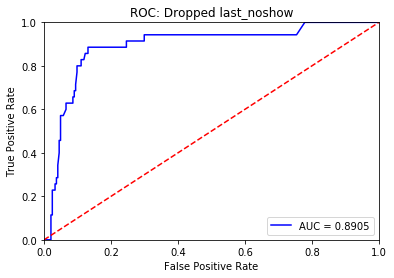

(0.8709677419354839, 0.8904566744730679)

In [31]:
run_regression(X,y,0,1,'ROC: Dropped last_noshow')

In [32]:
iterate_drop_cols(X,y,feature_cols)

Dropping last_day_services : Score is 0.8710 and ROC AUC is 0.8905
Dropping last_receipt_tot : Score is 0.8746 and ROC AUC is 0.8864
Dropping last_prod_flag : Score is 0.8710 and ROC AUC is 0.8894
Dropping last_cumrev : Score is 0.8710 and ROC AUC is 0.8886
Dropping last_cumbook : Score is 0.8674 and ROC AUC is 0.8895
Dropping last_cumstyle : Score is 0.8710 and ROC AUC is 0.8898
Dropping last_cumcolor : Score is 0.8710 and ROC AUC is 0.8888
Dropping last_cumcatratio : Score is 0.8710 and ROC AUC is 0.8915
Dropping last_cumprod : Score is 0.8674 and ROC AUC is 0.8902
Dropping last_cumcancel : Score is 0.8674 and ROC AUC is 0.8887
Dropping last_cumnoshow : Score is 0.8710 and ROC AUC is 0.8844
Dropping recency : Score is 0.8674 and ROC AUC is 0.8802
Dropping book_tod_afternoon : Score is 0.8638 and ROC AUC is 0.7895
Dropping book_tod_evening : Score is 0.8710 and ROC AUC is 0.8554
Dropping book_tod_morning : Score is 0.8710 and ROC AUC is 0.7845
Dropping last_tod_afternoon : Score is 0.

In [33]:
# Backward Elimination
feature_cols=list(X)
feature_cols.remove('last_day_services')
feature_cols.remove('last_cumcatratio')
feature_cols.remove('last_cumprod')

#print(feature_cols)
X=X.loc[:,feature_cols]
X.head(10)

,last_receipt_tot,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumcancel,last_cumnoshow,recency,book_tod_afternoon,book_tod_evening,book_tod_morning,last_tod_afternoon,last_tod_evening,last_tod_morning,book_dow_Friday,book_dow_Monday,book_dow_Saturday,book_dow_Sunday,book_dow_Thursday,book_dow_Tuesday,book_dow_Wednesday,last_dow_Friday,last_dow_Monday,last_dow_Saturday,last_dow_Sunday,last_dow_Thursday,last_dow_Tuesday,last_dow_Wednesday,book_category_COLOR,book_category_MISC,book_category_STYLE,last_category_COLOR,last_category_MISC,last_category_STYLE
0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.684431,1.0,0.205329,0.10,0.055556,0.142857,0.0,0.0,0.263158,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0
3,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.091432,0.0,0.027429,0.05,0.055556,0.000000,0.0,0.0,0.067669,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
5,0.143678,0.0,0.070533,0.10,0.111111,0.000000,0.0,0.0,0.105263,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
6,0.091432,0.0,0.113636,0.15,0.166667,0.000000,0.0,0.0,0.105263,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
7,0.091432,0.0,0.113636,0.15,0.166667,0.000000,0.0,0.0,0.105263,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
8,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0.198537,1.0,0.023511,0.05,0.055556,0.000000,0.0,0.0,0.270677,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


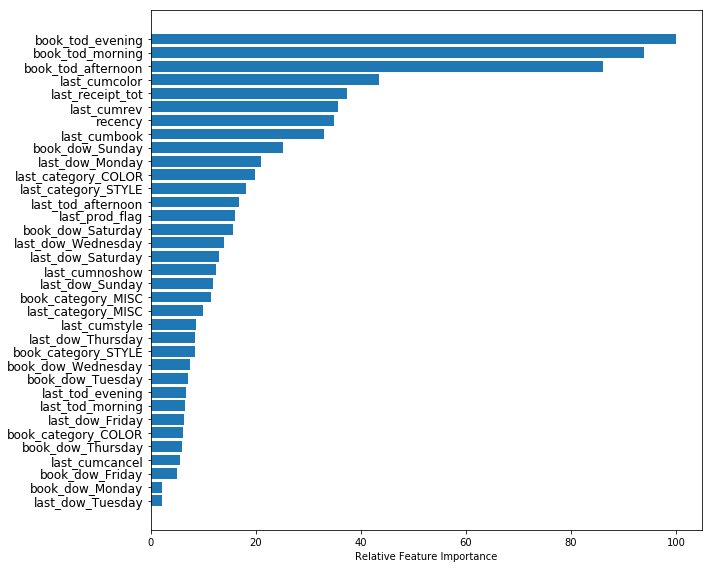

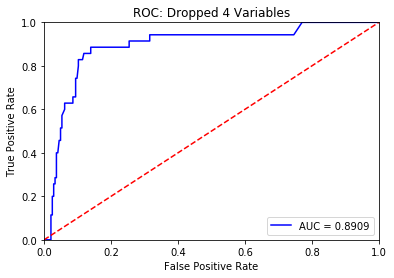

(0.8709677419354839, 0.8909250585480094)

In [34]:
run_regression(X,y,1,1,'ROC: Dropped 4 Variables')

<a id='conclusion'></a>
### Conclusion

Backward Elimination Takes AUC from 0.8851 to 0.8909.  The model predicts 4 out of 33 noshows in 274 test bookings with 1 false positive.